In [3]:
import pandas as pd
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram

In [4]:
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

from sklearn.datasets import load_iris
iris_data = load_iris(return_X_y=False, as_frame=True)
iris_data.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


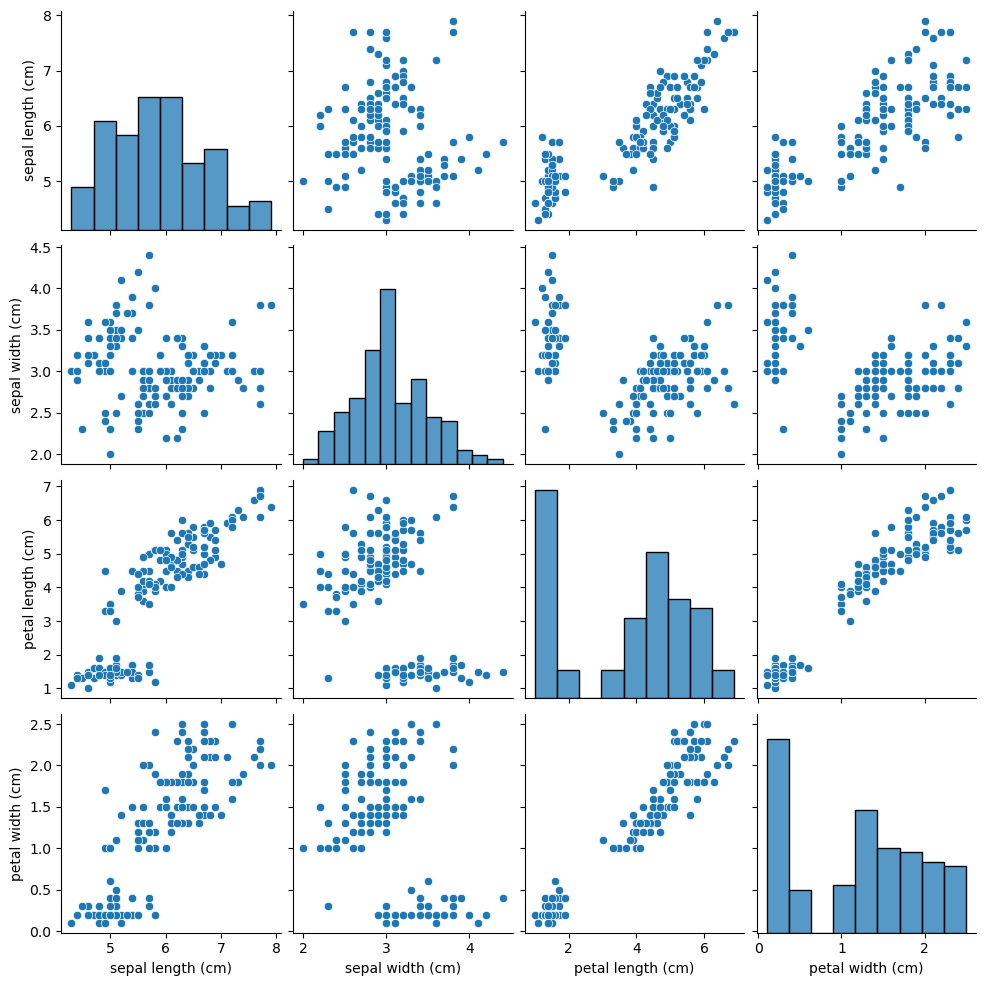

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
sns.pairplot(iris_data.data)
plt.show()

In [6]:
X = iris_data.data
target_labels = iris_data

In [7]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [30]:
a = np.ma.array([0, 0, 1], mask=False)
a.mask[1] = True
idxs = np.argwhere(a == a.min())
print(idxs)
print(type(idxs))
0 in idxs

[[0]]
<class 'numpy.ndarray'>


True

In [65]:
a = np.zeros(1, dtype=np.int32)
a.nbytes

4

In [86]:
from sys import getsizeof

N = int(35e+3)
a = np.zeros((N, N), dtype=np.float64)
b = np.ma.array(a)
mask = np.zeros((N,), dtype=bool)
size = lambda x: x.nbytes * 1e-9

print(size(a))
print(size(b.mask))
print(size(mask))
del a, b, mask

9.8
1e-09
3.5000000000000004e-05


In [ ]:
a = np.randint(10)
print(a)
a[a[:, 2].argsort()]

In [ ]:
class NNChainClustering():
    def __init__(self, n_clusters=2, metric='euclidean', linkage='average'):
        self.n_clusters = n_clusters

        metric_choices = {
            'euclidean': lambda a, b: np.sqrt(((a-b) ** 2).sum()),
            'precomputed': None
        }
        try:
            metric_func = metric_choices[metric]
        except KeyError as e:
            raise ValueError(
                f"Unknown metric."
            ) from e
        self._metric_func = metric_func

        def ward_join(p, q, D):
            N_p = np.count_nonzero(self.labels_ == p)
            N_q = np.count_nonzero(self.labels_ == q)
            D_t = np.ndarray((D.shape[0]))  # new array
            assert D[p][q] == np.min(D)

            non_masked = np.nonzero(~(D.mask[p] | D.mask[q]))
            for r in list(non_masked[0]):
                N_r = np.count_nonzero(self.labels_ == r)
                D_t[r] = np.sqrt(((N_r + N_p) * D[p][r] ** 2
                                  + (N_r + N_q) * D[q][r] ** 2
                                  - N_r * D[p][q] ** 2) / (N_p + N_q + N_r))
                pass

            return (D_t)

        linkage_choices = {
            'single': lambda i, j, D: np.minimum(D[i], D[j]),
            'average': lambda i, j, D: (D[i]+D[j])/2,
            'complete': lambda i, j, D: np.maximum(D[i], D[j]),
            'ward': ward_join
        }
        try:
            join_func = linkage_choices[linkage]
        except KeyError as e:
            raise ValueError(
                f"Unknown linkage. Should be one of {linkage_choices.keys()}"
            ) from e
        if linkage == 'ward' and metric != 'euclidean':
            raise ValueError(
                f"Only euclidean disance is availible for ward's method."
            )
        self._join_func = join_func
        self._linkage = linkage

        self.distances = None
        self.children_ = None

    def __compute_distances(self, X):
        N = X.shape[0]
        matrix = np.empty((N, N))
        for i in range(N):
            for j in range(N):
                dist = self._metric_func(X[i], X[j])
                matrix[i, j] = dist
        self.distances = matrix

    def fit(self, X):
        if type(X) == pd.core.frame.DataFrame:
                    X = X.to_numpy()

        if self._metric_func != None:
            self.__compute_distances(X)
        else:
            self.distances = X
        
        outputs = self.__core()

    def __core(self, X):
        N = self.distances.shape[0]
        node_labels = list(range(N))

        self.children_ = np.ndarray((N-1, 2), dtype='int')
        self.distances_ = np.ndarray((N-1))
        self.labels_ = np.arange(N)

        new_node_label = N
        chain = []
        outputs = []
        cluster_sizes = np.ones(2*N - 1) # N existing clusters and (N - 1) new (merged)
        while len(node_labels) > 1:
            if len(chain) <= 3:
                a = node_labels[0]
                chain.append(a)
                b = node_labels[1]
            else:
                a = chain[-4]
                b = chain[-3]
                chain.pop(-1)
                chain.pop(-2)
                chain.pop.(-3)
            while True: # repeat until
                distances = np.ma.array(self.distances, mask=False)
                distances.mask[c] = True # ignore dist[c, c]
                all_min_idxs = np.argwhere(self.distances == self.distances.min())
                c = b if b in all_min_idxs else all_min_idxs[0] # prefer b
                a, b = c, a
                chain.append(c)    
                if len(chain) > 3 and a = chain[-3]: break

            node_labels.remove(a)            
            node_labels.remove(b)

            n = new_node_label
            cluster_sizes[n] = cluster_sizes[a] + cluster_sizes[b]
            d[n, x] = d[x, n] = self.__join_func(a, b)
            node_labels.append(n)
            new_node_label += 1 

            self.children_[]

In [1]:
# from hierarchical_clustering import NNChainClustering

In [ ]:
%%time
linkage_types = ['ward', 'complete', 'average', 'single']
hclust = dict()
for linkage_type in linkage_types:
    model = NNChainClustering(linkage=linkage_type)
    clustering = model.fit(X)
    hclust[linkage_type] = clustering

CPU times: total: 1.8 s
Wall time: 1.85 s


In [88]:
from hierarchical_clustering import AgglomerativeClustering

In [89]:
%%time
linkage_types = ['ward', 'complete', 'average', 'single']
hclust = dict()
for linkage_type in linkage_types:
    model = AgglomerativeClustering(linkage=linkage_type)
    clustering = model.fit(X)
    hclust[linkage_type] = clustering

CPU times: total: 3.11 s
Wall time: 1min 34s


In [91]:
model.labels_

array([117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
        50, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 117, 117, 117, 117, 117, 117], dtype=int64)

In [163]:
from scipy.cluster.hierarchy import fcluster

def get_linkage_matrix(model):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

def get_node_labels(linkage_matrix, n_clusters=None, threshold=None):
    assert n_clusters is not None or threshold is not None, \
        "either n_clusters or threshold should be supplied"

    if n_clusters is not None: 
        node_labels = fcluster(linkage_matrix, linkage_matrix[-n_clusters, 2])
    else:
        node_labels = fcluster(linkage_matrix, threshold, criterion='distance')

    last_n_merges = linkage_matrix[linkage_matrix[:, 2] > linkage_colors[linkage_type]]
    n_clusters = last_n_merges.shape[0] + 1
    print(last_n_merges)
    print(node_labels)

    return node_labels

def plot_dendrogram(model, color_threshold=None, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = get_linkage_matrix(model)
    node_labels = get_node_labels(linkage_matrix, threshold=color_threshold)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, color_threshold=color_threshold, **kwargs)
    return linkage_matrix, node_labels

[[293.   292.     5.12  63.  ]
 [296.   295.     9.3  100.  ]
 [294.   297.    21.37 150.  ]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 3 2 3 2 3 2 3 3 2 3 2 3 2 3 3 2 3 2 2 2 2
 2 2 2 4 2 3 3 3 3 2 3 2 2 2 3 3 3 2 3 3 3 3 3 2 3 3 4 2 4 4 4 4 3 4 4 4 4
 4 4 2 2 4 4 4 4 2 4 2 4 2 4 4 2 2 4 4 4 4 4 2 4 4 4 4 2 4 4 4 2 4 4 4 2 4
 4 2]
[[292.   284.     2.24  60.  ]
 [287.   288.     2.43  50.  ]
 [294.   290.     3.21  72.  ]
 [295.   293.     4.02  78.  ]
 [297.   296.     7.09 150.  ]]
[1 1 1 1 1 2 1 1 1 1 2 2 1 1 2 2 2 1 2 2 2 2 1 2 2 1 2 1 1 1 1 2 2 2 1 1 2
 1 1 1 1 1 1 2 2 1 2 1 2 1 4 4 4 3 4 3 4 3 4 3 3 3 3 4 3 4 3 3 4 3 4 3 4 4
 4 4 4 4 4 3 3 3 3 4 3 4 4 4 3 3 3 4 3 3 3 3 3 4 3 3 5 4 6 5 5 6 3 6 5 6 5
 4 5 4 4 5 5 6 6 4 5 4 6 4 5 6 4 4 5 6 6 6 5 4 4 6 5 5 4 5 5 5 4 5 5 5 4 5
 5 4]
[[288.   286.     1.05  41.  ]
 [283.   285.     1.08  12.  ]
 [277.    41.     1.12  20.  ]
 [289.   276.     1.19  44.  ]
 [287.   106. 

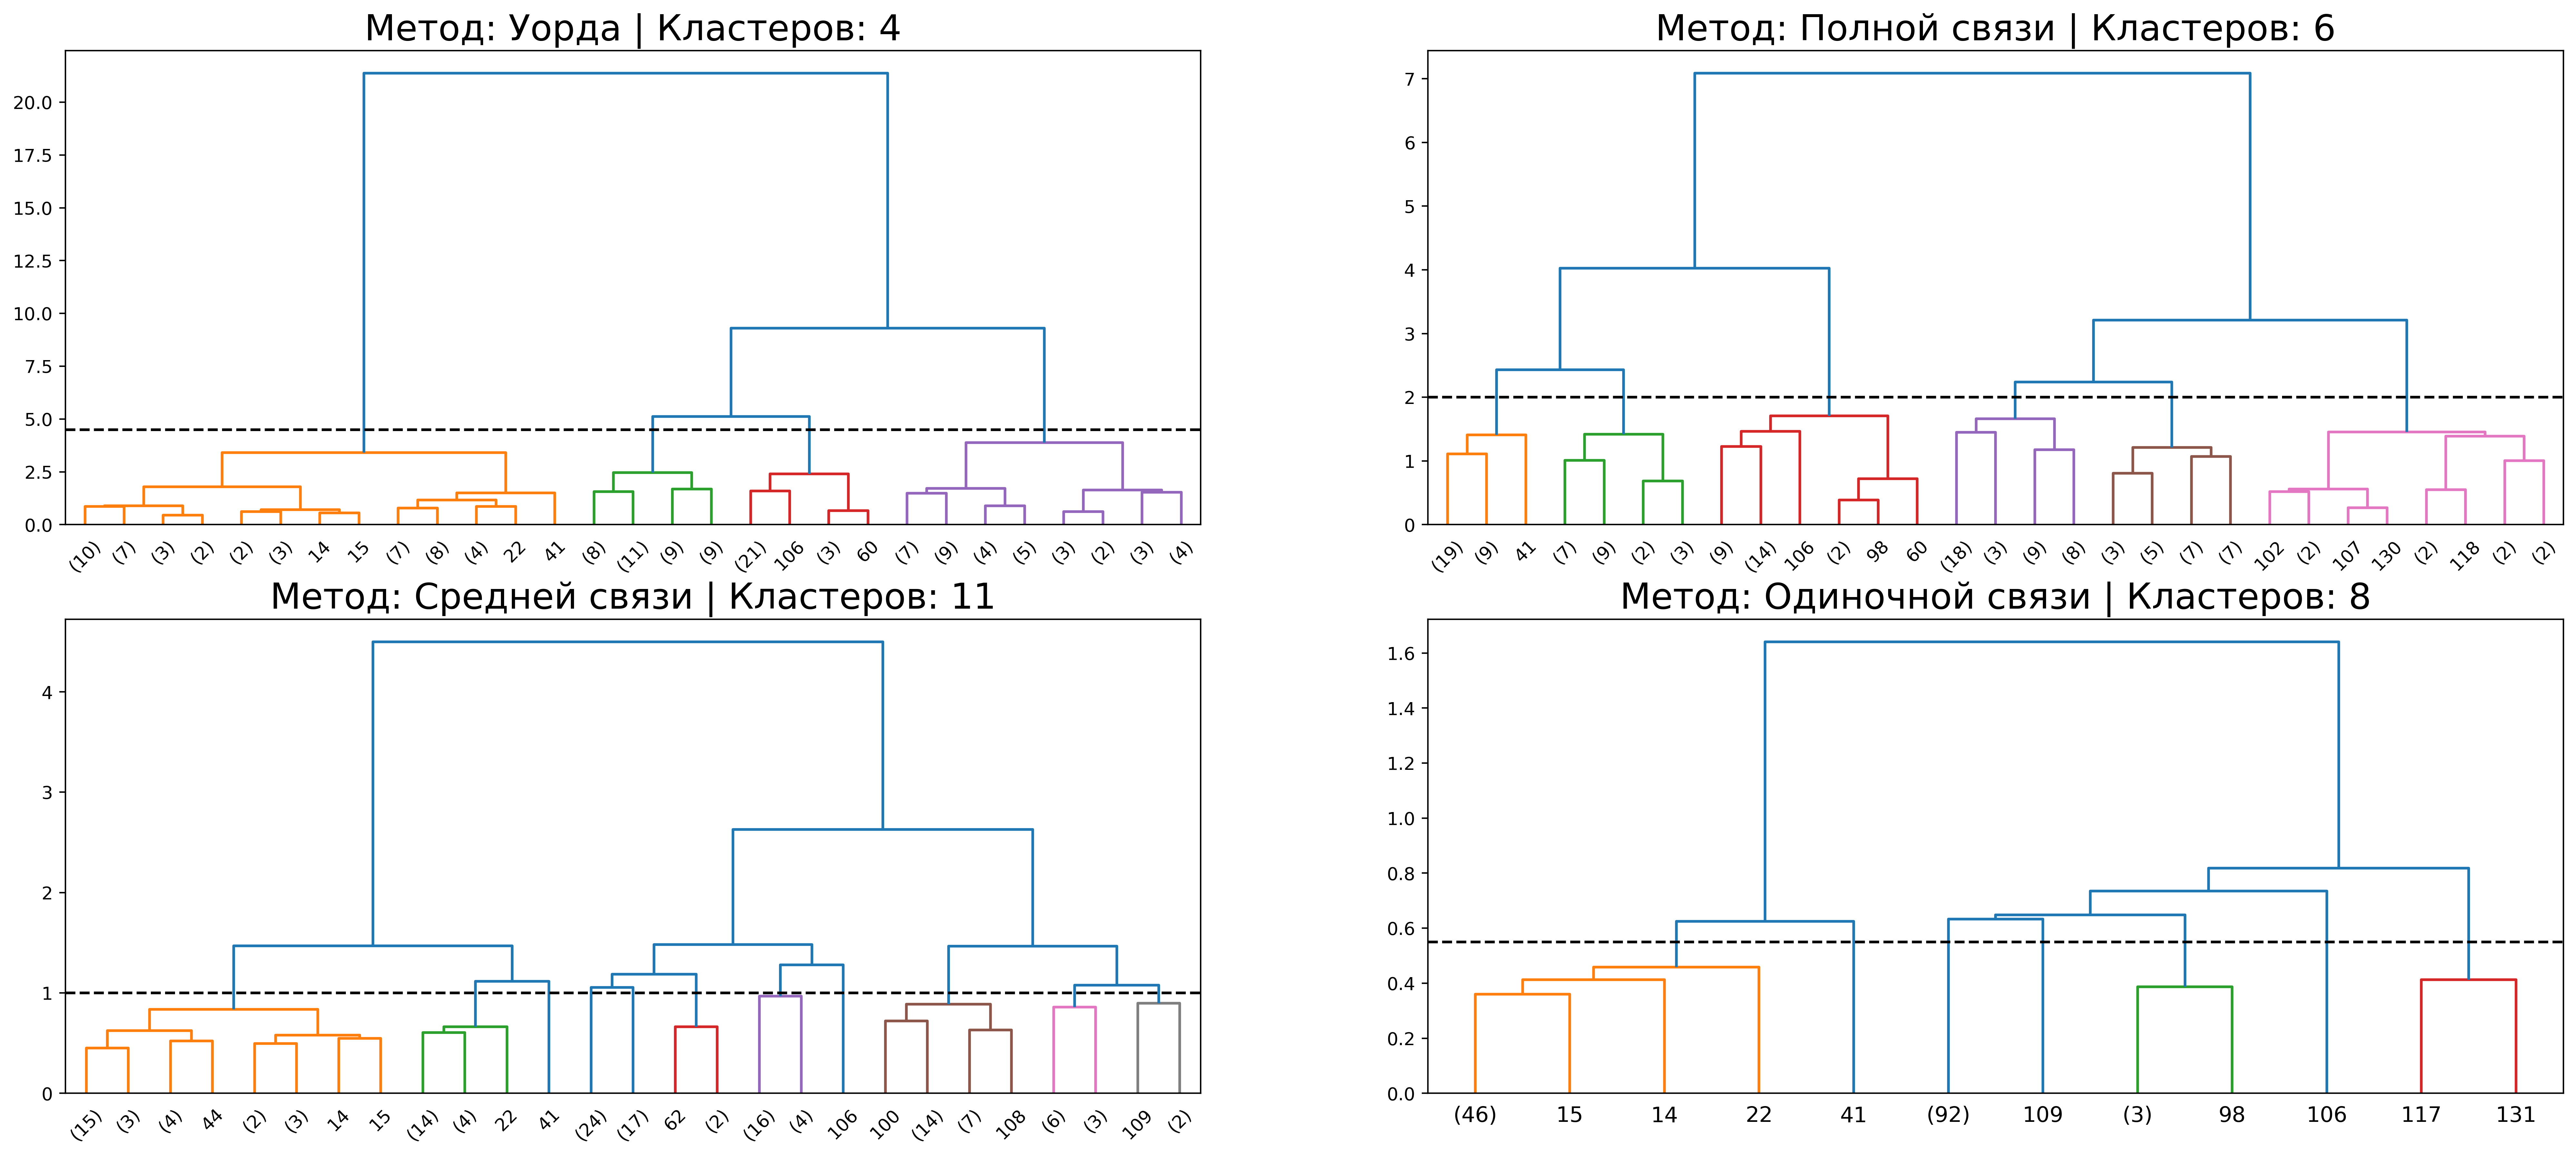

In [164]:
# TODO: fix cluster counting

cutoff_thresholds = [4.5, 2, 1, 0.55]
linkage_colors = dict(zip(linkage_types, cutoff_thresholds))
labels = ['Уорда', 'Полной связи', "Средней связи", "Одиночной связи"]
linkage_labels = dict(zip(linkage_types, labels))

mpl.rcParams.update(mpl.rcParamsDefault)
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    linkage_matrix, node_labels = plot_dendrogram(
        model=hclust[linkage_type],
        truncate_mode="level",
        p=4,
        ax=axs[axs_ind],
        labels=None,
        color_threshold = linkage_colors[linkage_type]
        )

    n_clusters = len(np.unique(node_labels))
    title = f"Метод: {linkage_labels[linkage_type]} | Кластеров: {n_clusters}"
    axs[axs_ind].set_title(title, fontsize=20)
    axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')

# fig.tight_layout()
fig.set_size_inches(25, 10.5)
fig.set_dpi(400)
plt.show()

In [126]:
a = np.array([1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4])
np.unique(a)

array([1, 2, 3, 4])

In [134]:
linkage_type

'single'

In [133]:
linkage_matrix[linkage_matrix[:, 2] > 0.5]

array([[287.  , 220.  ,   0.51,  86.  ],
       [288.  , 277.  ,   0.53,  89.  ],
       [289.  , 135.  ,   0.54,  90.  ],
       [290.  , 134.  ,   0.54,  91.  ],
       [291.  , 108.  ,   0.56,  92.  ],
       [285.  ,  41.  ,   0.62,  50.  ],
       [292.  , 109.  ,   0.63,  93.  ],
       [294.  , 273.  ,   0.65,  97.  ],
       [295.  , 106.  ,   0.73,  98.  ],
       [296.  , 279.  ,   0.82, 100.  ],
       [293.  , 297.  ,   1.64, 150.  ]])

In [131]:
linkage_matrix[linkage_matrix[:, 2] > 0.5].shape[0]

11

In [124]:
print(linkage_matrix)
n_clusters = fcluster(linkage_matrix, 0.5)
len(np.unique(n_clusters))

[[1.01e+02 1.42e+02 0.00e+00 2.00e+00]
 [7.00e+00 3.90e+01 1.00e-01 2.00e+00]
 [0.00e+00 1.70e+01 1.00e-01 2.00e+00]
 [9.00e+00 3.40e+01 1.00e-01 2.00e+00]
 [1.28e+02 1.32e+02 1.00e-01 2.00e+00]
 [1.00e+01 4.80e+01 1.00e-01 2.00e+00]
 [1.52e+02 4.00e+01 1.41e-01 3.00e+00]
 [4.00e+00 3.70e+01 1.41e-01 2.00e+00]
 [1.90e+01 2.10e+01 1.41e-01 2.00e+00]
 [1.56e+02 1.57e+02 1.41e-01 5.00e+00]
 [2.90e+01 3.00e+01 1.41e-01 2.00e+00]
 [5.70e+01 9.30e+01 1.41e-01 2.00e+00]
 [8.00e+01 8.10e+01 1.41e-01 2.00e+00]
 [1.16e+02 1.37e+02 1.41e-01 2.00e+00]
 [8.00e+00 3.80e+01 1.41e-01 2.00e+00]
 [1.58e+02 4.60e+01 1.41e-01 3.00e+00]
 [1.59e+02 1.51e+02 1.41e-01 7.00e+00]
 [1.66e+02 4.90e+01 1.41e-01 8.00e+00]
 [1.00e+00 1.53e+02 1.41e-01 3.00e+00]
 [3.00e+00 4.70e+01 1.41e-01 2.00e+00]
 [2.70e+01 2.80e+01 1.41e-01 2.00e+00]
 [8.20e+01 9.20e+01 1.41e-01 2.00e+00]
 [9.50e+01 9.60e+01 1.41e-01 2.00e+00]
 [1.27e+02 1.38e+02 1.41e-01 2.00e+00]
 [2.00e+00 1.69e+02 1.41e-01 3.00e+00]
 [1.68e+02 4.50e+01 1.41e

106

In [9]:
from sklearn.cluster import AgglomerativeClustering as AC_sklearn

In [10]:
%%time
linkage_types = ['ward', 'complete', 'average', 'single']
hclust_sklearn = dict()
for linkage_type in linkage_types:
    model = AC_sklearn(linkage=linkage_type, n_clusters=None,
                                    distance_threshold=0,
                                    compute_distances=True)
    clustering = model.fit(X)
    hclust_sklearn[linkage_type] = clustering

CPU times: total: 31.2 ms
Wall time: 19.1 ms


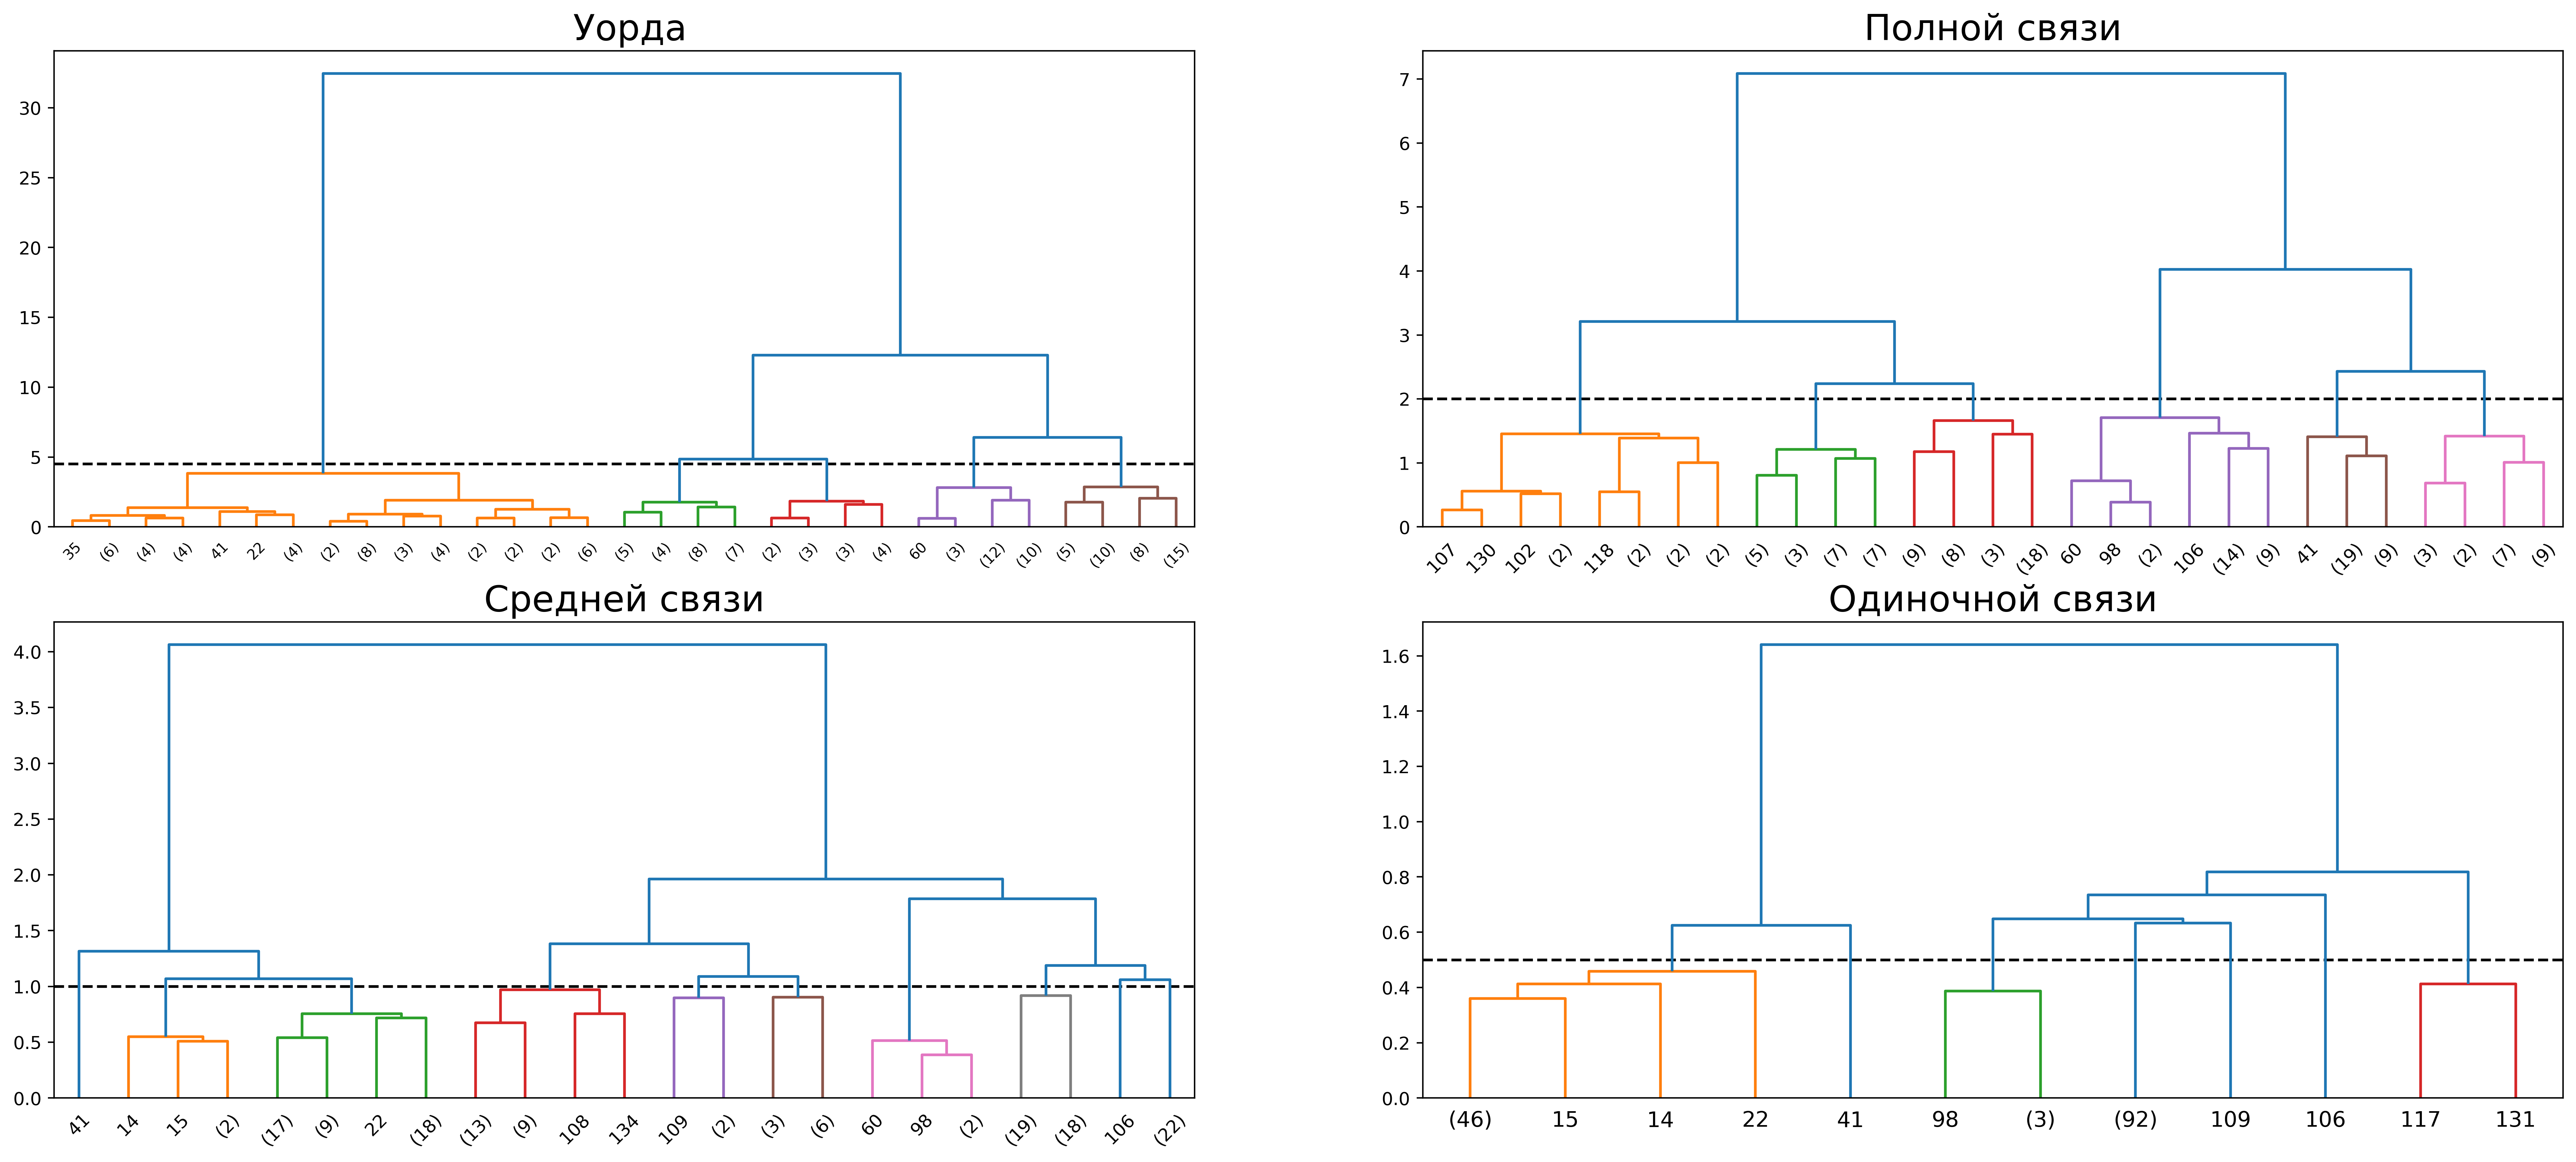

In [11]:
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    axs[axs_ind].set_title(linkage_labels[linkage_type],
                           fontsize=20)
    axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')
    linkage_matrix = plot_dendrogram(
        model=hclust_sklearn[linkage_type],
        truncate_mode="level",
        p=4,
        ax=axs[axs_ind],
        labels=None,
        color_threshold = linkage_colors[linkage_type]
        )

# fig.tight_layout()
fig.set_size_inches(25, 10.5)
fig.set_dpi(400)
plt.show()